## 목차
1. 환경 설정 및 라이브러리 설치
2. 로그 설정 및 예외 처리 준비
3. 데이터 로드 및 전처리
4. 특징 분석 및 선택
5. 특징 엔지니어링
6. 데이터 준비 및 GPU 설정
7. 모델 정의
    - 7.1 LSTM Autoencoder 정의
    - 7.2 LSTM Classifier 정의
8. 모델 학습
    - 8.1 LSTM Autoencoder 학습
    - 8.2 LSTM Classifier 학습
9. 모델 앙상블 및 통합
10. 모델 평가 및 검증
11. 결론

## 1. 환경 설정 및 라이브러리 설치

In [1]:
# pip install pandas numpy scikit-learn torch torchvision matplotlib optuna joblib tqdm seaborn logging

## 2. 로그 설정 및 예외 처리 준비

> `logging` 모듈을 사용하여 로그를 설정하고, 예외 처리를 위한 기본 구성

In [2]:
import logging
import sys

# 로그 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s', handlers=[
    logging.StreamHandler(sys.stdout),
    logging.FileHandler("./Log/model_training.log")
])

# 예외 처리 데코레이터
def exception_handler(func):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            logging.exception(f"에러 발생: {e}")
            raise e
    return wrapper

## 3. 데이터 로드 및 전처리

### 3.1 데이터 로드

> 데이터를 로드하고 기본적인 전처리를 수행

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import tqdm

@exception_handler
def load_data(data_path):
    # 데이터 타입 지정 (메모리 최적화)
    dtype_dict = {
        'HEARTBEAT': 'float32',
        'TEMPERATURE': 'float32',
        'OUTSIDETEMPERATURE': 'float32',
        'LATITUDE': 'float32',
        'LONGITUDE': 'float32',
        'SPEED': 'float32',
        'X': 'float32',
        'Y': 'float32',
        'Z': 'float32'
    }

    # 날짜 형식 파싱
    parse_dates = ['VITALDATE', 'CHECKTIME', 'WORKDATE']

    # 데이터 로드
    logging.info("데이터 로드 중...")
    df = pd.read_csv(data_path, dtype=dtype_dict, parse_dates=parse_dates)
    logging.info(f"데이터셋 크기: {df.shape}")
    return df

# 데이터 경로
data_path = './dataset/RiskPrediction_Dataset.csv'
df = load_data(data_path)

2024-11-14 16:53:58,212 [INFO] NumExpr defaulting to 8 threads.
2024-11-14 16:53:59,934 [INFO] 데이터 로드 중...
2024-11-14 16:58:47,300 [INFO] 데이터셋 크기: (30526925, 12)


### 3.2 결측치 처리

In [4]:
@exception_handler
def handle_missing_values(df):
    numeric_cols = ['HEARTBEAT', 
                    'TEMPERATURE', 
                    'OUTSIDETEMPERATURE',
                    'LATITUDE', 
                    'LONGITUDE',
                    'SPEED',
                    'X',
                    'Y', 
                    'Z']
    logging.info("결측치 처리 중...")
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    return df

df = handle_missing_values(df)

2024-11-14 16:58:47,309 [INFO] 결측치 처리 중...


### 3.3 특성 엔지니어링

In [5]:
@exception_handler
def feature_engineering(df):
    logging.info("특성 엔지니어링 진행 중...")
    # 날짜 및 시간에서 시간, 분, 초 추출
    df['VITAL_HOUR'] = df['VITALDATE'].dt.hour
    df['VITAL_MINUTE'] = df['VITALDATE'].dt.minute
    df['VITAL_SECOND'] = df['VITALDATE'].dt.second

    df['CHECK_HOUR'] = df['CHECKTIME'].dt.hour
    df['CHECK_MINUTE'] = df['CHECKTIME'].dt.minute
    df['CHECK_SECOND'] = df['CHECKTIME'].dt.second

    # 원본 날짜 컬럼 삭제
    df = df.drop(columns=['VITALDATE', 'CHECKTIME', 'WORKDATE'])
    return df

df = feature_engineering(df)

2024-11-14 16:58:50,042 [INFO] 특성 엔지니어링 진행 중...


### 3.4 스케일링

In [6]:
@exception_handler
def scale_data(df):
    logging.info("데이터 스케일링 중...")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    # 스케일러 저장
    joblib.dump(scaler, './Scaler1/scaler.joblib')
    logging.info("스케일러 저장 완료.")
    return scaled_data

scaled_data = scale_data(df)

2024-11-14 16:59:00,020 [INFO] 데이터 스케일링 중...
2024-11-14 16:59:06,819 [INFO] 스케일러 저장 완료.


## 4. 특징 분석 및 선택

2024-11-14 16:59:07,855 [INFO] 특징 분석 및 선택 진행 중...


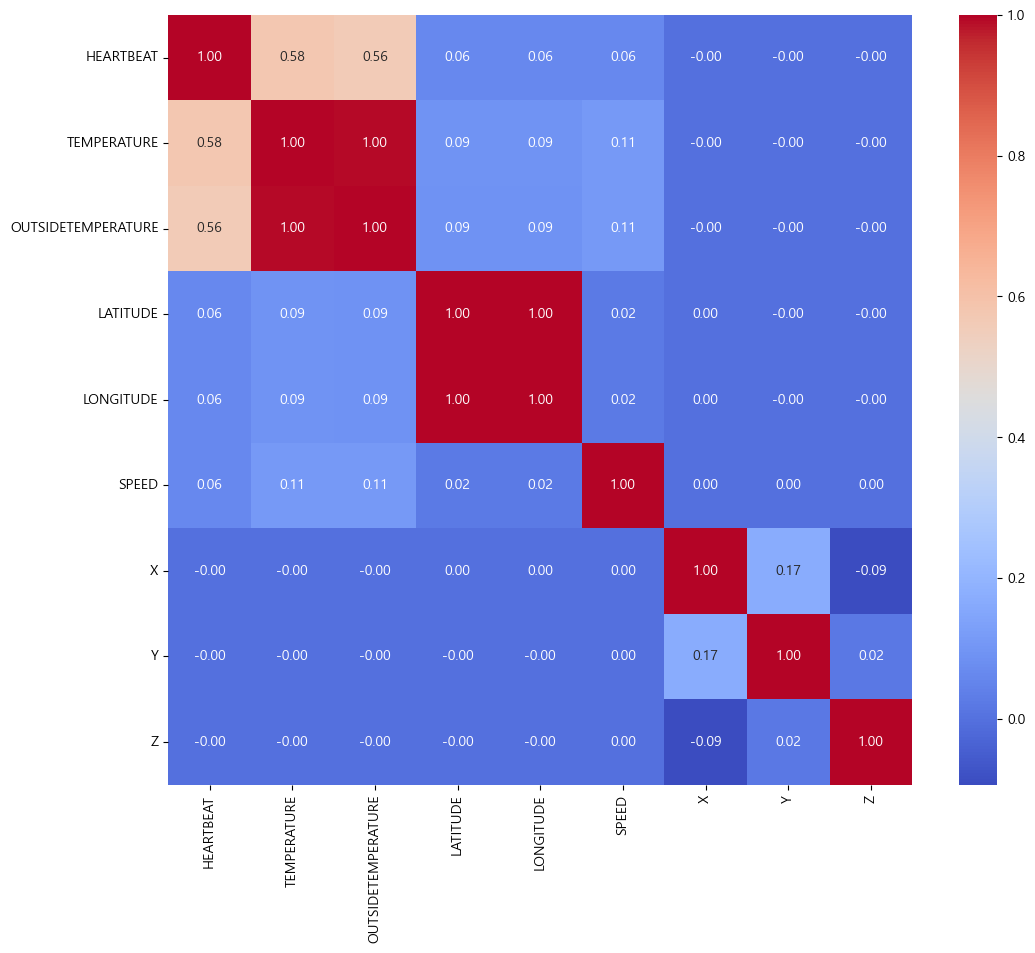

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

@exception_handler
def feature_analysis(df):
    logging.info("특징 분석 및 선택 진행 중...")
    # 상관 관계 분석
    numeric_cols = df.select_dtypes(include=['float32', 'int64']).columns
    corr_matrix = df[numeric_cols].corr()

    # 히트맵 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()

    # 중요하지 않거나 중복되는 특징 제거
    # 상관 관계가 높은 특징들 중 하나를 선택적으로 제거
    # df = df.drop(columns=['LONGITUDE'])

    return df

df = feature_analysis(df)

## 5. 특징 엔지니어링

> 새로운 특징을 생성하고, 필요한 경우 기존 특징을 변환함

In [8]:
@exception_handler
def additional_feature_engineering(df):
    logging.info("추가적인 특징 엔지니어링 진행 중...")
    # 이동 평균, 변화율 등 생성
    df['HEARTBEAT_DIFF'] = df['HEARTBEAT'].diff().fillna(0)
    df['TEMPERATURE_DIFF'] = df['TEMPERATURE'].diff().fillna(0)

    # 시간에 따른 특징 생성
    df['TIME_SIN'] = np.sin(2 * np.pi * df['VITAL_HOUR'] / 24)
    df['TIME_COS'] = np.cos(2 * np.pi * df['VITAL_HOUR'] / 24)

    return df

df = additional_feature_engineering(df)

2024-11-14 16:59:15,098 [INFO] 추가적인 특징 엔지니어링 진행 중...


> 스케일링을 다시 수행

In [9]:
scaled_data = scale_data(df)

2024-11-14 16:59:16,191 [INFO] 데이터 스케일링 중...
2024-11-14 16:59:25,012 [INFO] 스케일러 저장 완료.


## 6. 데이터 준비 및 GPU 설정

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset

@exception_handler
def prepare_data(scaled_data):
    logging.info("데이터 준비 및 GPU 설정 중...")
    # GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"사용 중인 디바이스: {device}")

    # 텐서로 변환
    data_tensor = torch.tensor(scaled_data, dtype=torch.float32)

    # 시퀸스 데이터 생성 (LSTM 입력을 위해)
    sequence_length = 10  # 시퀸스 길이
    sequences = []
    for i in range(len(data_tensor) - sequence_length):
        sequences.append(data_tensor[i:i + sequence_length])

    sequences = torch.stack(sequences)
    logging.info(f"시퀸스 데이터 크기: {sequences.shape}")

    return sequences, device

data_sequences, device = prepare_data(scaled_data)

2024-11-14 16:59:30,626 [INFO] 데이터 준비 및 GPU 설정 중...
2024-11-14 16:59:30,754 [INFO] 사용 중인 디바이스: cuda
2024-11-14 17:03:48,177 [INFO] 시퀸스 데이터 크기: torch.Size([30526915, 10, 19])


## 7. 모델 정의

### 7.1 LSTM Autoencoder 정의

In [11]:
import torch.nn as nn

class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim

        self.encoder = nn.LSTM(
            input_size = n_features,
            hidden_size = embedding_dim,
            num_layers = 1,
            batch_first = True
        )

        self.decoder = nn.LSTM(
            input_size = embedding_dim,
            hidden_size = n_features,
            num_layers = 1,
            batch_first = True
        )

    def forward(self, x):
        # 인코더
        _, (hidden, _) = self.encoder(x)
        # 반복적으로 디코더에 입력
        decoder_input = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)
        output, (hidden, cell) = self.decoder(decoder_input)
        return output

input_dim = data_sequences.shape[2]

### 7.2 LSTM Classifier 정의

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)  # 최종 출력층

    def forward(self, x):
        # 초기 은닉 상태와 셀 상태 설정
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시점의 은닉 상태를 사용
        out = out[:, -1, :]
        out = self.fc(out)
        return out

## 8. 모델 학습

### 8.1 LSTM Autoencoder 학습

In [13]:
from tqdm import tqdm

@exception_handler
def train_lstm_autoencoder(data_sequences, input_dim, device):
    logging.info("LSTM Autoencoder 모델 학습 시작...")

    model = LSTMAutoencoder(seq_len=data_sequences.shape[1],
                            n_features=input_dim,
                            embedding_dim=64).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    batch_size = 64
    dataset = TensorDataset(data_sequences)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc="LSTM Autoencoder 학습 진행"):
        epoch_loss = 0
        for data in dataloader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(dataloader.dataset)
        epoch_losses.append(epoch_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            logging.info(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {epoch_loss:.6f}")

    logging.info("LSTM Autoencoder 모델 학습 완료.")

    # 손실 시각화
    plt.figure()
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title('LSTM Autoencoder 학습 손실')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # 모델 저장
    torch.save(model.state_dict(), './Models/lstm_autoencoder.pth')
    logging.info("LSTM Autoencoder 모델 저장 완료.")

    return model

lstm_autoencoder_model = train_lstm_autoencoder(data_sequences, input_dim, device)

2024-11-14 17:03:48,727 [INFO] LSTM Autoencoder 모델 학습 시작...


LSTM Autoencoder 학습 진행:   0%|                                                               | 0/50 [00:00<?, ?it/s]

2024-11-14 17:27:36,414 [INFO] Epoch [1 / 50], Loss: 0.448699


LSTM Autoencoder 학습 진행:   2%|█                                                 | 1/50 [32:17<26:22:13, 1937.43s/it]


KeyboardInterrupt: 

### 8.2 LSTM Classifier 학습

> 레이블이 필요한 지도 학습 모델, 여기서는 랜덤하게 레이블을 생성하여 학습

In [ ]:
@exception_handler
def train_lstm_classifier(data_sequences, device):
    logging.info("LSTM Classifier 모델 학습 시작...")

    # 랜덤 레이블 생성
    num_classes = 6    # 6개의 행동 분류
    labels = torch.randint(0, num_classes, (len(data_sequences),))

    dataset = TensorDataset(data_sequences, labels)
    batch_size = 64
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True)

    model = LSTMClassifier(input_size=input_dim,
                           hidden_size=128,
                           num_layers=2,
                           num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    model.train()
    for epoch in tqdm(range(num_epochs), desc="LSTM Classifier 학습 진행"):
        epoch_loss = 0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(dataloader.dataset)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            logging.info(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {epoch_loss:.6f}")

    logging.info("LSTM Classifier 모델 학습 완료.")

    # 모델 저장
    torch.save(model.state_dict(), './Models/lstm_classifier.pth')
    logging.info("LSTM Classifier 모델 저장 완료.")

    return model

lstm_classifier_model = train_lstm_classifier(data_sequences, device)

## 9. 모델 앙상블 및 통합

> LSTM Autoencoder의 재구성 오차와 LSTM Classifier의 예측 결과를 결합하여 최종 위험 점수를 계산함.

In [ ]:
@exception_handler
def ensemble_models(lstm_autoencoder_model, lstm_classifier_model, data_sequences, device):
    logging.info("모델 앙상블 및 통합 진행 중...")

    lstm_autoencoder_model.eval()
    lstm_classifier_model.eval()

    with torch.no_grad():
        inputs = data_sequences.to(device)
        # Autoencoder 재구성 오차 계산
        reconstructed = lstm_autoencoder_model(inputs)
        ae_loss = nn.functional.mse_loss(reconstructed, inputs, reduction='none')
        ae_loss = ae_loss.mean(dim=(1, 2)).cpu().numpy()

        # Classifier 예측 결과
        outputs = lstm_classifier_model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    # 이상치 점수와 행동 분류 결과를 결합하여 위험 점수 계산
    # 각 행동의 위험도에 따라 가중치를 부여할 수 있음
    risk_socres = ae_loss  # 단순히 재구성 오차를 위험 점수로 사용

    # 위험 점수에 따라 이상치 여부 판정
    threshold = np.percentile(risk_scores, 95)
    anomalies = risk_scores > threshold

    logging.info(f"탐지된 이상치 수: {np.sum(anomalies)}")

    # 결과 저장
    df_results = pd.DataFrame({
        'Risk_Score': risk_scores,
        'Anomaly': anomalies,
        'Predicted_Action': predictions
    })

    return df_results, threshold

df_results, threshold = ensemble_models(lstm_autoencoder_model,
                                        lstm_classifier_model,
                                        data_sequences,
                                        device)

## 10. 모델 평가 및 검증

> 재구성 오차 분포를 시각화하고, 이상치 탐지 결과를 분석함

In [ ]:
@exception_handler
def evaluate_models(def_results, threshold):
    logging.info("모델 평가 및 검증 진행 중...")

    # 재구성 오차 히스토그램
    plt.figure(figsize=(10, 6))
    sns.histplot(df_results['Risk_Score'], bins=50, kde=True, color='purple')
    plt.axvline(threshold, color='red', linestyle='--', label='임계값')
    plt.title('재구성 오차 분포 및 이상치 임계값')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # 이상치 데이터 확인
    anomalies = df_results[df_results['Anomaly']]
    logging.info(f"이상치 데이터 샘플:\n{anomalies.head()}")

evaluate_models(df_results, threshold)

## 11. 결론

> `RiskPrediction_Dataset.csv` 데이터를 활용하여 작업자의 위험 예측 및 행동 파악을 위한 모델을 구현

- **데이터 로드 및 전처리**: 데이터의 결측치를 처리하고, 필요한 특징을 추출하였습니다.
- **특징 분석 및 엔지니어링**: 데이터의 특성을 분석하고, 새로운 특징을 생성하였습니다.
- **모델 정의 및 학습**: LSTM Autoencoder를 활용한 이상치 탐지와 LSTM Classifier를 활용한 행동 인식 모델을 학습하였습니다.
- __모델 앙상블 및 통합__: 두 모델의 결과를 결합하여 최종 위험 점수를 계산하였습니다.
- __모델 평가 및 검증__: 재구성 오차 분포를 시각화하고, 이상치 탐지 결과를 분석하였습니다.
- __로그 및 예외 처리__: logging 모듈과 예외 처리 데코레이터를 사용하여 코드의 진행 상황을 추적하고 에러를 처리하였습니다.
- __시각화__: matplotlib과 seaborn을 사용하여 데이터와 모델의 결과를 시각화하였습니다.